In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import math
import seaborn as sns
sns.set()


from copy import deepcopy
from collections import defaultdict

# Columns with categorical data that needs to be encoded
categorical_cols = ['serve', 'hitpoint', 'outside.sideline', 
                    'outside.baseline', 'same.side', 'server.is.impact.player', 'outcome', 
                    'gender' , 'previous.hitpoint']

# Columns in the Data That Should Be Scaled
scaled_data = ['rally', 'speed', 'net.clearance', 'distance.from.sideline', 'depth', 'player.distance.travelled', 
               'player.impact.depth', 'player.impact.distance.from.center', 'player.depth', 
               'player.distance.from.center', 'previous.speed', 'previous.net.clearance', 
               'previous.distance.from.sideline', 'previous.depth', 'opponent.depth', 
               'opponent.distance.from.center', 'previous.time.to.net', 'player.impact.distance.from.center']

# Columns to be dropped
train_dropcols = ['id', 'train', 'gender', 'same.side', 'server.is.impact.player', 'outside.baseline', 
            'previous.hitpoint', 'hitpoint', 'rally', 'serve', 'outside.sideline', 'player.distance.from.center',
            'player.distance.from.each.other.length', 'player.distance.from.each.other.width',
           'player.impact.distance.from.center', 'second.serve',
           'opponent.distance.from.center', 'player.from.net.penultimate', 'bw.player.distance.penultimate'
           ,'net.clearance.difference', 'depth', 'first.serve', 'B.previous.hitpoint', 'F.previous.hitpoint',
            'U.previous.hitpoint', 'V.previous.hitpoint', 'V.hitpoint', 'B.hitpoint', 'F.hitpoint', 'U.hitpoint',
            'previous.time.to.net']

# Columns to be dropped
test_dropcols = ['id', 'train', 'gender', 'same.side', 'server.is.impact.player', 'outside.baseline', 
            'previous.hitpoint', 'hitpoint', 'rally', 'serve', 'outside.sideline', 'player.distance.from.center',
            'player.distance.from.each.other.length', 'player.distance.from.each.other.width',
           'player.impact.distance.from.center', 
           'opponent.distance.from.center', 'player.from.net.penultimate', 'bw.player.distance.penultimate'
           ,'net.clearance.difference', 'depth']

# Load Data
raw_mens_train = pd.read_csv('tennis_data/mens_train_file.csv')
raw_mens_test = pd.read_csv("tennis_data/mens_test_file.csv")
raw_womens_train = pd.read_csv('tennis_data/womens_train_file.csv')
raw_womens_test = pd.read_csv("tennis_data/womens_test_file.csv")

# NO IMPACTS- gender, train, id rally
# LOW IMPACT- 'server.is.impact.player', 'previous.hitpoint', 'same.side',  'outside.baseline',
# MED IMPACT- 'previous.time.to.net', 'opponent.distance.from.center', 'opponent.depth',  'previous.depth',  
# 'previous.distance.from.sideline', 'previous.net.clearance', 'player.distance.from.center',  'player.depth',
# 'player.impact.distance.from.center', 'player.distance.travelled', 'distance.from.sideline',
# HIGH IMPACT- 'previous.speed', 'player.impact.depth', 'depth', 'speed'


# Feature Engineering

def feature_engineer(data):
    data['speed.difference'] = data['speed'] - data['previous.speed']
    data['net.clearance.difference'] = data['net.clearance'] - data['previous.net.clearance']
    data['true.distance.from.sideline'] = [dist if not boolean else (dist * -1) for dist, boolean in 
                                                 zip(data['distance.from.sideline'], 
                                                     data['outside.sideline'])]

    data['true.distance.from.baseline'] = [dist if not boolean else (dist * -1) for dist, boolean in 
                                                    zip(data['depth'], 
                                                    data['outside.baseline'])]

    # Opponent distance to net + player distance to net
    data['player.distance.from.each.other.length'] = data['player.depth'] + data['opponent.depth']

    # Opponent distance from center + player distance to center
    data['player.distance.from.each.other.width'] = [math.fabs(p_center - o_center)
                                                             if boolean 
                                                             else p_center + o_center
                                                             for p_center, o_center, boolean in 
                                                             zip(data['player.distance.from.center'], 
                                                                 data['opponent.distance.from.center'], 
                                                                 data['same.side'])]

    # Straight line distance between players
    data['bw.player.distance.penultimate'] = [math.hypot(length, width)
                                                 for length, width in 
                                                 zip(data['player.distance.from.each.other.length'], 
                                                     data['player.distance.from.each.other.width'])]

    # Distance penultimate shot was made from net- previous to net (s) * penultimate shot (m/s)
    data['player.from.net.penultimate'] = data['previous.speed'] * data['previous.time.to.net']
    
    data['x'] = data['net.clearance'] * data['previous.net.clearance']

    
    return data
    
mens_train = feature_engineer(raw_mens_train)
mens_test = feature_engineer(raw_mens_test)

womens_train = feature_engineer(raw_womens_train)
womens_test = feature_engineer(raw_womens_test)

# Encode Categorical Data
def encode(train, test):
    
    # Retain All LabelEncoder as a dictionary
    d = defaultdict(LabelEncoder)
    # Encode all the columns
    train[categorical_cols] = train[categorical_cols].apply(lambda x: d[x.name].fit_transform(x))
#     print(train)
    test_ids = test['id']
    # Inverse the encoding
    # data.apply(lambda x: d[x.name].inverse_transform(x))
    
    # Using dictionary d to label future data
    temp = deepcopy(categorical_cols)
    temp.remove('outcome')
    e = deepcopy(d)
    del e['outcome']
    
    test[temp] = test[temp].apply(lambda x: e[x.name].transform(x))
    train = train.drop(train_dropcols, axis=1)
    
    test = test.drop(test_dropcols + ['outcome'], axis=1)
    return train, test, test_ids, d
    

mens_train, mens_test, mens_test_ids , mens_d = encode(mens_train, mens_test)
# womens_train, womens_test, womens_test_ids , womens_d = encode(womens_train, womens_test)


In [2]:
# for i, x in enumerate(mens_train.columns):
#     print((i,x))
    
mens_train_X = mens_train.loc[:, mens_train.columns != 'outcome']
mens_train_y = mens_train['outcome']

womens_train_X = womens_train.loc[:, womens_train.columns != 'outcome']
womens_train_y = womens_train['outcome']

mens_train_X.head()
# womens_train_X, val_womens_X = train_test_split(womens_train, test_size=0.2, shuffle=True, random_state=42)
# womens_X_train = womens_train_X.loc[:, womens_train_X.columns != 'outcome']
# womens_y_train = womens_train_X['outcome']
# womens_X_val = val_womens_X.loc[:, val_womens_X.columns != 'outcome']
# womens_y_val = val_womens_X['outcome']

,speed,net.clearance,distance.from.sideline,player.distance.travelled,player.impact.depth,player.depth,previous.speed,previous.net.clearance,previous.distance.from.sideline,previous.depth,opponent.depth,speed.difference,true.distance.from.sideline,true.distance.from.baseline,x
0,35.515042,-0.021725,3.474766,1.467570,14.1758,13.6704,32.313592,1.350533,2.449182,0.705435,12.5628,3.201450,3.474766,6.797621,-0.029340
1,33.382640,1.114202,2.540801,2.311931,12.7396,12.6358,34.060788,0.760499,0.583291,3.856600,12.3544,-0.678148,2.540801,-2.608708,0.847350
2,22.316690,-0.254046,3.533166,3.903728,15.3782,13.6996,39.806628,0.377732,1.115250,2.908892,13.8620,-17.489938,3.533166,9.435749,-0.095961
3,36.837309,0.766694,0.586885,0.583745,13.7308,13.1492,25.018818,1.239033,3.256695,0.557554,14.2596,11.818491,-0.586885,3.342180,0.949959
4,35.544208,0.116162,0.918725,2.333456,15.1992,14.1310,36.790979,0.165731,1.431146,3.945317,11.3658,-1.246771,0.918725,5.499119,0.019252


In [3]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

mens_xgb_model = XGBClassifier(n_estimators=100, random_state= 1, learning_rate= 0.1, subsample= 0.9, 
                               colsample_bytree= 1.0, eval_metric= 'mlogloss', max_depth= 5, 
                               min_child_weight= 1, gamma= 0)

y_pred = cross_val_predict(mens_xgb_model, mens_train_X, mens_train_y,cv=8)
confusion_matrix(mens_train_y,y_pred)

array([[ 898,  255,   45],
       [ 202, 1847,   69],
       [  32,   36, 1616]])

In [6]:
from sklearn.model_selection import cross_val_score

CV = 8

mens_xgb_model = XGBClassifier(n_estimators=100, random_state= 1, learning_rate= 0.1, subsample= 0.9, 
                               colsample_bytree= 1.0, eval_metric= 'mlogloss', max_depth= 5, 
                               min_child_weight= 1)
m_loss = cross_val_score(mens_xgb_model, mens_train_X, mens_train_y, scoring='neg_log_loss', cv = CV, n_jobs=-1)
m_acc = cross_val_score(mens_xgb_model, mens_train_X, mens_train_y, scoring='accuracy', cv = CV, n_jobs=-1)

print('CV: ' + str(CV))
print("Accuracy: {:.4%}".format(np.mean(m_acc)))
print("Log Loss: {}".format(np.mean(m_loss)))


CV: 8
Accuracy: 87.2224%
Log Loss: -0.32319987751520407


In [4]:
womens_xgb_model = XGBClassifier(n_estimators=100, random_state= 1, learning_rate= 0.1, subsample= 0.9, 
                               colsample_bytree= 0.8, eval_metric= 'mlogloss', max_depth= 5, 
                               min_child_weight= 1)
w_loss = cross_val_score(womens_xgb_model, womens_train_X, womens_train_y, scoring='neg_log_loss', cv = CV, n_jobs=-1)
w_acc = cross_val_score(womens_xgb_model, womens_train_X, womens_train_y, scoring='accuracy', cv = CV, n_jobs=-1)

print('CV: ' + str(CV))
print("Accuracy: {:.4%}".format(np.mean(w_acc)))
print("Log Loss: {}".format(np.mean(w_loss)))


CV: 2
Accuracy: 86.7200%
Log Loss: -0.34853508791988713


Accuracy: 87.1000%
Log Loss: 0.3232567913229577
----------------
('speed', 0.028064992)
('net.clearance', 0.13490891)
('distance.from.sideline', 0.041851304)
('player.distance.travelled', 0.064992614)
('player.impact.depth', 0.06597735)
('player.depth', 0.043328408)
('previous.speed', 0.063023143)
('previous.net.clearance', 0.065484986)
('previous.distance.from.sideline', 0.068931557)
('previous.depth', 0.05169867)
('opponent.depth', 0.097488925)
('speed.difference', 0.074839979)
('true.distance.from.sideline', 0.063515507)
('true.distance.from.baseline', 0.10536681)
('x', 0.030526834)


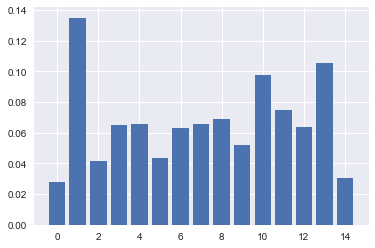

In [5]:
mens_train_XX, val_mens_XX = train_test_split(mens_train, test_size=0.2, shuffle=True)
mens_X_train = mens_train_XX.loc[:, mens_train_XX.columns != 'outcome']
mens_y_train = mens_train_XX['outcome']
mens_X_val = val_mens_XX.loc[:, val_mens_XX.columns != 'outcome']
mens_y_val = val_mens_XX['outcome']

mens_model = XGBClassifier(eval_metric='mlogloss')
mens_model.fit(mens_X_train, mens_y_train)
mens_y_prob_pred = mens_model.predict_proba(mens_X_val)
mens_y_pred = mens_model.predict(mens_X_val)
mens_loss = log_loss(mens_y_val, mens_y_prob_pred)
mens_acc = accuracy_score(mens_y_val, mens_y_pred)
print("Accuracy: {:.4%}".format(mens_acc))
print("Log Loss: {}".format(mens_loss))
print('----------------')

import matplotlib.pyplot as plt

for x in zip(mens_X_train,mens_model.feature_importances_):
    print(x)
plt.bar(range(len(mens_model.feature_importances_)), mens_model.feature_importances_)
plt.show()

In [ ]:
# # Recursive Feature Elimination
# from sklearn.feature_selection import RFE

# # create a base classifier used to evaluate a subset of attributes
# xgb_model = XGBClassifier()
# # create the RFE model and select 1 attributes
# rfe = RFE(xgb_model, 1)
# rfe = rfe.fit(mens_X_train, mens_y_train)
# # summarize the selection of the attributes
# print(rfe.estimator_)
# print(rfe.ranking_)
# print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), mens_X_train)))

In [ ]:
from sklearn.model_selection import GridSearchCV
# Paramter Tuning
# n_estimators = [100, 200, 300, 400, 500]
# learning_rate = [0.0001, 0.001, 0.01, 0.1]

# def parameter_tuning():

cv_params = {'learning_rate': [0.001, 0.01, 0.1]}
ind_params = {'n_estimators': 100, 'seed':0,  'subsample': 0.9, 'colsample_bytree':1.0,
              'objective': 'multi:softprob', 'max_depth': 5, 'min_child_weight': 1}
optimized_GBM = GridSearchCV(XGBClassifier(**ind_params), 
                             cv_params, scoring = 'neg_log_loss', cv = 5, n_jobs = -1, verbose=3) 

optimized_GBM.fit(mens_train_X, mens_train_y)
#     grid_search = GridSearchCV(xgb_model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
#     grid_result = grid_search.fit(mens_train_X, mens_train_y)
#     print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [ ]:
optimized_GBM.grid_scores_

('speed', 0.056023221)
('net.clearance', 0.11044993)
('distance.from.sideline', 0.05834543)
('player.distance.travelled', 0.077358492)
('player.impact.depth', 0.051523946)
('player.depth', 0.055878084)
('previous.speed', 0.058490567)
('previous.net.clearance', 0.069230773)
('previous.distance.from.sideline', 0.074165456)
('previous.depth', 0.066908561)
('opponent.depth', 0.056023221)
('previous.time.to.net', 0.056023221)
('speed.difference', 0.056458637)
('true.distance.from.sideline', 0.059796806)
('true.distance.from.baseline', 0.093323655)


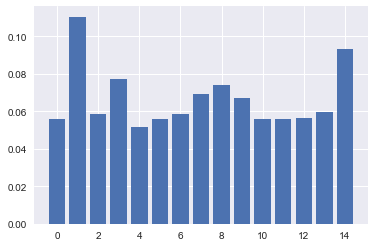

In [6]:
mens_model = XGBClassifier(n_estimators=100, seed= 0, learning_rate= 0.1, subsample= 0.9, 
                               colsample_bytree= 0.8, eval_metric= 'mlogloss', max_depth= 5, 
                               min_child_weight= 1, gamma= 0)
mens_model.fit(mens_train_X, mens_train_y)
mens_test_pred = pd.DataFrame(mens_model.predict_proba(mens_test))

womens_model = XGBClassifier(n_estimators=100, seed= 0, learning_rate= 0.1, subsample= 0.9, 
                               colsample_bytree= 0.8, eval_metric= 'mlogloss', max_depth= 5, 
                               min_child_weight= 1, gamma= 0)
womens_model.fit(womens_train_X, womens_train_y)
womens_test_pred = pd.DataFrame(womens_model.predict_proba(womens_test))

for x in zip(mens_train_X, mens_model.feature_importances_):
    print(x)
plt.bar(range(len(mens_model.feature_importances_)), mens_model.feature_importances_)
plt.show()

In [ ]:
def append_gender(data, gender):
    return str(data) + '_' + str(gender)

def create_column_ids(mens_id, womens_id):
    mens_test_id_col = mens_id.apply(append_gender, args=('mens',))
    womens_test_id_col = womens_id.apply(append_gender, args=('womens',))

    combined_id = np.concatenate((mens_test_id_col, womens_test_id_col))
    
    return pd.DataFrame(combined_id)

column_ids = create_column_ids(mens_test_ids, womens_test_ids)

combined_test_predictions = pd.concat([mens_test_pred, womens_test_pred], axis=0)
combined_test_predictions.columns = ['FE', 'UE', 'W']
combined_test_predictions.reset_index(inplace=True, drop=True)
combined_test_predictions.head()

In [ ]:
def format_submission(predictions):
    format_file = pd.read_csv('tennis_data/AUS_SubmissionFormat.csv')
#     format_file['submission_id']
    # result = create_column_ids(mens_test_id, womens_test_id, result)
    final = pd.concat([column_ids, format_file[['train']], predictions], axis=1, )
    final.columns = ['submission_id', 'train', 'FE', 'UE', 'W']
    final = final.set_index(list(final[['submission_id']])).T
    correct_order = list(format_file['submission_id'])
    final_sorted = final[correct_order].T.reset_index()
    cols = ['submission_id', 'train', 'UE', 'FE', 'W']
    final_sorted = final_sorted[cols]
    return final_sorted

final_submission = format_submission(combined_test_predictions)
final_submission.head()
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
def save_file(data):
    data.to_csv('Submissions/SubmissionGB' + timestr + '.csv', index=False)
save_file(final_submission)